Train shape: (1460, 81)
Test shape: (1459, 80)
✅ Encoding & Scaling completed successfully!

🚀 Training and evaluating models...

RandomForest: Mean CV RMSE = 0.14406
GradientBoosting: Mean CV RMSE = 0.12908
XGBoost: Mean CV RMSE = 0.12795

✅ Best Model: XGBoost (CV RMSE = 0.12795)

📊 Validation Performance:
MAE  = 0.0878
MSE  = 0.0172
RMSE = 0.1313
R²   = 0.9076


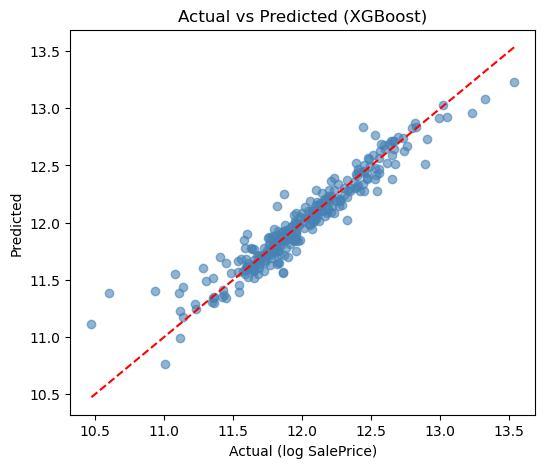


✅ Submission file saved as 'submission.csv'


In [74]:
# ✅ House Price Prediction – Complete Model Pipeline (Fixed Version)

# =======================
# 📦 Import Libraries
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# =======================
# 📥 Load Data
# =======================
train_path = "train.csv"
test_path = "test.csv"
sample_path = "sample_submission.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
sample_sub = pd.read_csv(sample_path)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

# =======================
# 🧹 Step 1: Handle Missing Values
# =======================
threshold = 0.4 * len(df_train)
cols_to_drop = df_train.columns[df_train.isnull().mean() > 0.4]
df_train.drop(columns=cols_to_drop, inplace=True)
df_test.drop(columns=[c for c in cols_to_drop if c in df_test.columns], inplace=True)

# Fill missing numeric with median, categorical with mode
num_cols = df_train.select_dtypes(include=['int64','float64']).columns
cat_cols = df_train.select_dtypes(include=['object']).columns

for col in num_cols:
    med = df_train[col].median()
    df_train[col].fillna(med, inplace=True)
    if col in df_test.columns:
        df_test[col].fillna(med, inplace=True)

for col in cat_cols:
    mode = df_train[col].mode()[0]
    df_train[col].fillna(mode, inplace=True)
    if col in df_test.columns:
        df_test[col].fillna(mode, inplace=True)

# Add missing column in df_test (MasVnrType)
if 'MasVnrType' not in df_test.columns:
    df_test['MasVnrType'] = 'None'

# =======================
# 🔁 Step 2: Align Columns
# =======================
missing_in_test = set(df_train.columns) - set(df_test.columns)
missing_in_train = set(df_test.columns) - set(df_train.columns)

for col in missing_in_test:
    if col != 'SalePrice':
        df_test[col] = 0
for col in missing_in_train:
    df_train[col] = 0

df_test = df_test[df_train.drop('SalePrice', axis=1).columns]

# =======================
# 🧠 Step 3: Encoding + Scaling (Fixed)
# =======================
y = np.log1p(df_train["SalePrice"])  # log-transform target
X_train = df_train.drop(["SalePrice"], axis=1)
X_test = df_test.copy()

# Convert all numeric-like columns to numeric safely
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = pd.to_numeric(X_train[col], errors='ignore')
        if X_train[col].dtype == 'object':
            X_train[col] = X_train[col].astype(str)
    if X_test[col].dtype == 'object':
        X_test[col] = pd.to_numeric(X_test[col], errors='ignore')
        if X_test[col].dtype == 'object':
            X_test[col] = X_test[col].astype(str)

# Label encode categorical columns consistently
cat_cols = X_train.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    le.fit(combined)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

# Convert all to numeric and fill any NaNs
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_train.median(), inplace=True)

# Standard Scaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("✅ Encoding & Scaling completed successfully!")

# =======================
# ⚙️ Step 4: Model Comparison
# =======================
models = {
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=3,
        min_samples_split=5, min_samples_leaf=4, subsample=0.8, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=3, subsample=0.8,
        colsample_bytree=0.8, random_state=42, n_jobs=-1)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print("\n🚀 Training and evaluating models...\n")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    rmse = np.sqrt(-scores)
    results[name] = rmse.mean()
    print(f"{name}: Mean CV RMSE = {rmse.mean():.5f}")

best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

print(f"\n✅ Best Model: {best_model_name} (CV RMSE = {results[best_model_name]:.5f})")

# =======================
# 🧩 Step 5: Train & Evaluate on Validation Split
# =======================
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)
best_model.fit(X_tr, y_tr)

y_pred_val = best_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_val)

print("\n📊 Validation Performance:")
print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

plt.figure(figsize=(6,5))
plt.scatter(y_val, y_pred_val, alpha=0.6, color='steelblue')
plt.xlabel("Actual (log SalePrice)")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.show()

# =======================
# 🏁 Step 6: Final Training & Submission
# =======================
best_model.fit(X_train, y)
y_pred_final = np.expm1(best_model.predict(X_test))  # inverse log-transform

submission = sample_sub.copy()
submission["SalePrice"] = y_pred_final
submission.to_csv("submission.csv", index=False)

print("\n✅ Submission file saved as 'submission.csv'")


In [75]:
print("Training Accuracy:", best_model.score(X_tr, y_tr)) 
print("Testing Accuracy:", best_model.score(X_val, y_val))

Training Accuracy: 0.9802512578459026
Testing Accuracy: 0.9826407422905479
